# Fun with language modelling

Если вы пропустили лекцию, то посмотрите слайды к ней — они где-то есть. Также полезно почитать:

* [Unreasonable effectiveness of RNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) (Andrej Karpathy)
* [Официальный гайд от TensorFlow](https://www.tensorflow.org/tutorials/sequences/recurrent)

Домашка сложная, но интересная. Рекомендуется заранее всё прочитать, чтобы понять, что от вас хотят.

Отсутствие багов и плохих практик в коде не гарантируется — можете переписать всё так, как подсказывает ваше сердце.

---

- Препроцессинг
- Модель и обучение (PyTorch)
- Генерация предложений
- Спеллчекер

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

import string
import csv
import numpy as np
import random
import re
from io import open
from tqdm import tqdm

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [0]:
!pip install torch==0.4.1

## Препроцессинг (2 балла)

Возьмите какие-нибудь сырые данные. Википедия, «Гарри Поттер», «Игра Престолов», твиты Тинькова — что угодно.

Для простоты будем делать char-level модель. Выкиньте из текстов все ненужные символы (можете оставить только алфавит и, возможно, пунктуацию). Сопоставьте всем различным символам свой номер. Удобно это хранить просто в питоновском словаре (`char2idx`). Для генерации вам потребуется ещё и обратный словарь (`idx2char`).

Заранее зарезервируйте там место под служебные символы: `<START>`, `<END>`, `<PAD>`, `<UNK>`.

Клёво будет написать отдельный класс, который делает токенизацию и детокенизацию.

Если у вас какой-то большой массив текста (скажем, статьи Википедии), вы можете просто нарезать из него кусочки фиксированной длины и так их подавать в модель.

(Опционально) Иногда вы хотите приключений и, скажем, разбить этот текст на предложения (`nltk.sent_tokenize`), и тогда все примеры будут разной длины. По соображениям производительности, вы не хотите использовать самые длинные и самые короткие сэмплы, поэтому имеет смысл обрезать их по длине.

### Описание

- Беру текст Игры Престолов
- Создаю класс с методами предобработки, добавления специальных символов, словарями
- Разделяю текст на предложения
- Соответственно, предложения являются примерами
- Будем генерировать предложения

In [0]:
PAD_token = 0 #<PAD>
START_token = 1 #<START>
END_token = 2 #<END>
UNK_token = 3 #<UNK>

In [0]:
class Vocab:
    
    
    def __init__(self, data):
        self.char2idx = {'<START>': START_token, '<END>': END_token, '<PAD>': PAD_token, '<UNK>': UNK_token}
        self.idx2char = {START_token: '<START>', END_token: '<END>',
                         PAD_token: "<PAD>", UNK_token: "<UNK>"}
        self.num_chars = 4
        self.maxlen = 200
        self.data = data
        
    
    def addChar(self, char):
        if char not in self.char2idx:
            self.char2idx[char] = self.num_chars
            self.idx2char[self.num_chars] = char
            self.num_chars += 1
            
    def clean(self, sequence):
        sequence = re.sub(r"([.!?,–:])", r" \1", sequence)
        sequence = re.sub(r"[^а-яА-Я.!?,–:]+", r" ", sequence)
        sequence = re.sub(r"\s+", r" ", sequence).strip()
        return sequence
        
        
    def tokenize_first(self, sequence, fit = True):
        if fit:
            for char in sequence:
                self.addChar(char)
        
        tokenized = [self.char2idx['<START>']]
        for char in sequence:
            try:
                tokenized.append(self.char2idx[char])
            except KeyError:
                tokenized.append(self.char2idx['<UNK>'])
        tokenized.append(self.char2idx['<END>'])
        
        if len(tokenized) > self.maxlen:
          tokenized = tokenized[:self.maxlen]
        
        return tokenized    
      
      
    def pad_tokenized(self, tokenized):
        if len(tokenized) < self.maxlen:
            for _ in range(self.maxlen - len(tokenized)):
                tokenized.append(self.char2idx['<PAD>'])
        return tokenized 
    
    
    def detokenize(self, sequence):
        return ''.join([self.idx2char[idx] for idx in sequence])
    
    
    def __len__(self):
        return len(self.char2idx)
    
    
    def transform(self, data = [], fit = True):
        if len(data) == 0:
            data = self.data
        for i in range(len(data)):
            data[i] = self.tokenize(data[i], fit)
        return data
    
    def transform_back(self, data = []):
        if len(data) == 0:
            data = self.data
        for i in range(len(data)):
            data[i] = self.detokenize(data[i])
        return data

In [0]:
with open('gdrive/My Drive/Colab Notebooks/Thrones.txt', 'r', encoding='Windows-1251') as data:
    data = data.read()

In [0]:
def lengths(data):
    return np.array([elem for elem in map(len, data)])

In [0]:
# обучите вокаб
tokenizer = Vocab(data)
data = tokenizer.clean(data)
tokenized_data = tokenizer.tokenize_first(data)

In [0]:
data_len = len(data)

In [0]:
data = nltk.sent_tokenize(data)

In [0]:
#Примеры
for i in range(10):
    print(random.choice(list(data)))
    print('-----')

Иного они не заслуживали , и я не буду из за них тревожить свой сон .
-----
Молодой рыцарь посмотрел на него с презрительной улыбкой : – В самом деле ?
-----
– И что , если так ?
-----
И каждый новый день , проведенный среди них , заставлял Джона презирать этот сброд все больше и больше .
-----
– И я приношу клятву , – проговорил мейстер Лювин .
-----
Бран Утро выдалось чистым и ясным , свежесть напоминала о близящемся конце лета .
-----
И мгновение спустя направился назад улыбаясь .
-----
Такая здесь жизнь , и тебе предстоит такая же судьба , как и всем остальным .
-----
Ты должен испить ее , хочешь этого или нет .
-----
Он то и был рожден , чтобы стать десницей короля и отцом королевы .
-----


In [0]:
test = data[4500:]
train = data[0:4500]

In [0]:
train_len = len(train)

In [0]:
encoded_train = [tokenizer.tokenize_first(sequence) for sequence in train]
encoded_test = [tokenizer.tokenize_first(sequence) for sequence in test]

## Модель (1 балл) и обучение (3 балла)

Примерно такое должно зайти:

* Эмбеддинг
* LSTM / GRU
* Дропаут
* Линейный слой
* Softmax

Рекомендуется некоторые части не писать самому, а пользоваться готовыми функциями из `tf.contrib.seq2seq`. Будет проще, если обернуть итоговую модель в `Estimator`.

### Описание
- Делаю на PyTorch

In [0]:
class LM(nn.Module):
    def __init__(self, 
                 vocab_size,
                 emb_dim, 
                 rnn_dim,
                 num_layers, 
                 dropout):
        
        super(LM, self).__init__()
        
        self.rnn_dim = rnn_dim
        
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(input_size = emb_dim, 
                            hidden_size = rnn_dim, 
                            num_layers = num_layers, 
                            dropout = dropout,
                            batch_first = True)
        
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(rnn_dim,vocab_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, inp, seq_length, hidden_states, use_temperature=False, temperature=1.0):
        embedded = self.embedding(inp)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, seq_length, batch_first=True)
        packed_output, (ht, ct) = self.lstm(packed_embedded, hidden_states)
        (lstm_output, length) = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        lstm_output = self.dropout(lstm_output)
        output_linear = self.linear(lstm_output)
        if use_temperature: output_linear = output_linear / temperature
        output = self.softmax(output_linear)
        return output, (ht, ct)

    def initLM(self, batch_size):
      return (Variable(torch.zeros(num_layers, batch_size, self.rnn_dim).cuda()), Variable(torch.zeros(num_layers, batch_size, self.rnn_dim)).cuda())

In [0]:
emb_dim = 1024
num_layers = 3
rnn_dim = 2048
dropout = 0.1
batch_size = 64
learning_rate = 0.0005
vocab_size = len(tokenizer.idx2char)

losses = []
test_losses = []
step_count = 0

epochs = 10

In [0]:
lm = LM(vocab_size, emb_dim, rnn_dim, num_layers, dropout).cuda()
loss_func = nn.CrossEntropyLoss(ignore_index=tokenizer.char2idx['<PAD>'])
optimizer = torch.optim.Adam(lm.parameters())

In [0]:
for _ in range(epochs):
  
    random.shuffle(encoded_train)
    batches = np.array_split(encoded_train, int(len(encoded_train)/batch_size))
    
    test_batches = np.array_split(encoded_test, int(len(encoded_test)/batch_size))
    
    
    #Обучение
    for batch in tqdm(batches):

        batch = list(batch)
        batch.sort(key=len, reverse=True)

        batch_input = [i[:-1] for i in batch]
        batch_target = [i[1:] for i in batch]
        
        batch_input_pad = np.array([tokenizer.pad_tokenized(i) for i in batch_input])
        batch_target_pad = np.array([tokenizer.pad_tokenized(i) for i in batch_target])

        input_var = Variable(torch.cuda.LongTensor(batch_input_pad))
        
        output, _ = lm(input_var, lengths(batch_input), 
                                  lm.initLM(len(batch_input)) ,
                                  use_temperature = False)
        
        flatten_output = output.contiguous()
        flatten_output = flatten_output.view(-1, vocab_size)
        flatten_target = Variable(torch.cuda.LongTensor(batch_target_pad.flatten()))
        
        loss = loss_func(flatten_output , flatten_target)
        losses.append(float(loss))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        step_count+=1
        
    #Валидация
    for batch in tqdm(test_batches):
      batch = list(batch)
      batch.sort(key=len, reverse=True)

      batch_input = [i[:-1] for i in batch]
      batch_target = [i[1:] for i in batch]

      batch_input_pad = np.array([tokenizer.pad_tokenized(i) for i in batch_input])
      batch_target_pad = np.array([tokenizer.pad_tokenized(i) for i in batch_target])

      input_var = Variable(torch.cuda.LongTensor(batch_input_pad))

      output, _ = lm(input_var, lengths(batch_input), 
                                lm.initLM(len(batch_input)) ,
                                use_temperature = False)
      
      flatten_output = output.contiguous()
      flatten_output = flatten_output.view(-1,vocab_size)
      flatten_target = Variable(torch.cuda.LongTensor(batch_target_pad.flatten()))
      
      loss = loss_func(flatten_output , flatten_target)
      test_losses.append(float(loss))
        

100%|██████████| 26/26 [00:52<00:00,  1.44s/it]


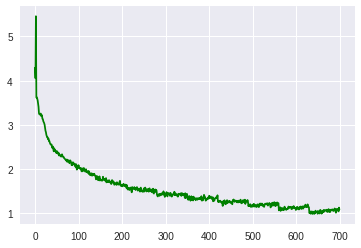

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(losses, 'g')

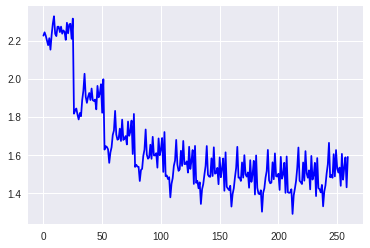

In [0]:
%matplotlib inline

plt.figure()
plt.plot(test_losses, 'b')

## Генерация предложений (3 балла)

* Поддерживайте hidden state при генерации. Не пересчитывайте ничего больше одного раза.
* Прикрутите температуру: это когда при сэмплировании все логиты (то, что перед софтмаксом) делятся на какое-то число (по умолчанию 1, тогда ничего не меняется). Температура позволяет делать trade-off между разнообразием и правдоподобием (подробнее — см. блог Карпатого).
* Ваша реализация должна уметь принимать строку seed — то, с чего должно начинаться сгенерированная строка.

Если сделаете все вышеперечисленное, то получите 2 балла. Если сделаете хоть какую-то генерацию, то 1 балл.

In [0]:
def generates_sequence(start_string, max_length, use_temperature = False, temperature=1.0):
    
    input_encoded = []
    for char in start_string:
        input_encoded.append(tokenizer.char2idx[char])

    top_index = 0
    result = start_string
    hidden = lm.initLM(1)
    
    input_var =Variable(torch.cuda.LongTensor([input_encoded]))
    
    while input_encoded[0] != tokenizer.char2idx['<END>']:
    
        
        output, hidden = lm(input_var,
                              np.array([len(input_encoded)]), 
                              hidden ,
                              use_temperature, temperature)

        input_encoded = [int(output.cpu().data.topk(1,dim=2)[1].numpy()[0][-1])]
       
        result+=tokenizer.idx2char[input_encoded[0]]
        
        if len(result) > max_length: break
        
        input_var = Variable(torch.cuda.LongTensor(input_encoded)).view(1,1)
        
    return result[:-5] #Чтобы выводить без <END>

In [0]:
for i in range(5):
    print(generates_sequence('Дыхан', 50))
    print('---')

Дыхание собственного отца .
---
Дыхание открытые каменные стены .
---
Дыхание собственных дракон .
---
Дыхание совершения , – проговорил он .
---
Дыхание собственное совершение .
---


In [0]:
for i in range(5):
    print(generates_sequence('О мире опасных', 100))
    print('---')

О мире опасных веселей .
---
О мире опасных прикосновением .
---
О мире опасных взглядом .
---
О мире опасных принцессой .
---
О мире опасных детей .
---


In [0]:
for i in range(5):
    print(generates_sequence('Тирио', 100))
    print('---')

Тирион поглядел на него .
---
Тирион поглядел на него .
---
Тирион поглядел на нее .
---
Тирион поглядел на него .
---
Тирион поглядел на него .
---


In [0]:
for i in range(5):
    print(generates_sequence('Кейт', 100, use_temperature=True, temperature=1))
    print('---')

Кейтилин поглядела на него .
---
Кейтилин поставила ее .
---
Кейтилин поглядела на него .
---
Кейтилин скоро , – проговорил он .
---
Кейтилин совершала ее .
---


In [0]:
for i in range(5):
    print(generates_sequence('Кейт', 100, use_temperature=True, temperature=1))
    print('---')

Кейтилин .
---
Кейтилин спросила своего коня .
---
Кейтилин .
---
Кейтилин сказала , что не сомневаться .
---
Кейтилин .
---


In [0]:
for i in range(5):
    print(generates_sequence('Тирио', 100, use_temperature=True, temperature=5))
    print('---')

Тирион поглядел на него .
---
Тирион поглядел на него .
---
Тирион поглядел на него .
---
Тирион поглядел на него .
---
Тирион поглядел на него .
---


In [0]:
for i in range(5):
    print(generates_sequence('И сказал', 100, use_temperature=True, temperature=5))
    print('---')

И сказала , что он подумал , что он послал своего короля .
---
И сказала , что он не понимает , что он поднял ее .
---
И сказал , что он поглядел на него .
---
И сказал , что он поглядел на него .
---
И сказал , что он не понимает , что она посмотрела на него .
---


In [0]:
for i in range(5):
    print(generates_sequence('Ста', 100, use_temperature=True, temperature=3))
    print('---')

Старки совершил ее .
---
Старки не смела подобраться с ней .
---
Старки не смелался со стол .
---
Старки поднял его .
---
Старки не смех .
---


### Посмотрим на test

In [0]:
for i in range(50, 100):
    print(generates_sequence(test[i][0:5], 100, use_temperature=True, temperature=3))
    print('---')

– А ты порадует меня , – сказал он .
---
– спросила она .
---
– Мика , – сказала она .
---
Он узнал , что на него не становился с королевскому грамкинов .
---
– Миллистый , – сказал он .
---
– Это не совсем сердце .
---
– Мой сестра , – сказал он .
---
– Остаток из постели , – проговорил он .
---
– Сын , – сказал он .
---
– Джон , – сказал он .
---
– Возле столов , – сказал он .
---
– Последний день , – сказал он .
---
Мика .
---
Джоффри , подобает этого .
---
– Ну что ж , – сказал он .
---
– Она погладила ее .
---
– Сам убил ее .
---
Сансе со скорбной .
---
Вино , подобает меня , пока они посмотрела на него .
---
– Ты не сомневайся , – сказал он .
---
Мика , подобая своего коня .
---
Это не сомневайся .
---
– А ты почему ты не сомневается в этом .
---
– Джон , – проговорил он .
---
– Но так , – сказал он .
---
Или так , что не сомневается в этом .
---
– Яркань , – сказал он .
---
– Остальные , – сказал он .
---
– завоеванное стороны , – проговорил он .
---
Санса находилась в сторону .

In [0]:
for i in range(50):
    print(generates_sequence(test[i][0:5], 100, use_temperature=True, temperature=3))
    print('---')

Воздух наполнял свое сестру .
---
Конь поднимали ее .
---
Да так и не посмотрел на него .
---
День , – проговорил он .
---
Они открытые камень .
---
Они поставили .
---
– Отец , – проговорил он .
---
– Моя мать , – проговорил он .
---
Поев из телохранители , – проговорил он .
---
Джоффри поглядел на него .
---
Голову , – проговорил он .
---
– А не поднимаю сестру , – проговорил он .
---
– спросил он .
---
– Сколько тебе не понимаете , что она поглядела на него .
---
– Положил ее , – проговорил он .
---
Там могу поставить ее , он подобает дома .
---
Он ударил ее .
---
– Джон Сноу , – покачал он .
---
– Потом , – покачала она .
---
Правда , – проговорил он .
---
А это не слышал .
---
Санса , – проговорил он .
---
– Не сомневаюсь , – покачал он .
---
– Джон наполовину решил , что он поглядел на него .
---
– Я хочу , чтобы показаться , – проговорил он .
---
– Джон направился к стене .
---
Шум своему служанки , он поглядел на него .
---
– Там , – сказал он .
---
– Со стены , – сказал он .
-

## Спеллчекер (1 балла)

Из языковой модели можно сделать простенький спеллчекер: можно визуализировать лоссы на каждом символе.

Бонус: можете усреднить перплексии по словам и выделять их, а не отдельные символы.

In [0]:
loss_func = nn.CrossEntropyLoss(ignore_index=tokenizer.char2idx['<PAD>'], reduce=False)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [0]:
from IPython.core.display import display, HTML

def print_colored(sequence, intensities, delimeter=''):
    html = delimeter.join([
        f'<span style="background: rgb({255}, {255-x}, {255-x})">{c}</span>'
        for c, x in zip(sequence, intensities) 
    ])
    display(HTML(html))

In [0]:
def spellcheck(sequence):
    
    tokenized_sequence = tokenizer.tokenize_first(sequence, fit=False)
    
    sequence_input = tokenized_sequence[:-1]
    sequence_target = tokenized_sequence[1:]
    
    input_pad = np.array([tokenizer.pad_tokenized(sequence_input)])
    target_pad = np.array([tokenizer.pad_tokenized(sequence_target)])
    
    input_var = Variable(torch.cuda.LongTensor(input_pad))
    
    output, _ = lm(input_var, lengths(input_pad), 
                     lm.initLM(len(input_pad)) ,
                     use_temperature = False)
    
    flatten_output = output.contiguous()
    flatten_output = flatten_output.view(-1, vocab_size)
    flatten_target = Variable(torch.cuda.LongTensor(target_pad.flatten()))
    loss = loss_func(flatten_output, flatten_target)
    loss = loss.tolist()
    
    cleared_loss = loss[0:len(sequence)]
    
    print_colored(sequence, np.array(cleared_loss)*10)
    

### Посмотрим на общих предложениях

In [0]:
sequences = ['В этом претложениии очен много очепяток .', 
             'Здесь появилась лишнняя буква .', 
             'В этом предложении все нормально .', 
             'Чтонибудь пишеться чериз дефис .', 
             'Слова нрпдзх не сущесдвует .',
             'Кейтилин .',
            'Налейте мне экспрессо .',
             'Эту домашку нужно сдать втечении двух недель .'
            ]

for sequence in sequences:
  losses = spellcheck(sequence)

### Посмотрим на специальных предложениях в духе Игры Престолов

In [0]:
sequences = ['Кейтелен .',
             'Тереон .',
             'И скозал он .',
             'По маему .',
             'Посторался .',
             'Ведела .',
             'И сказал : – По моему , не понимаешь , что он постарался .',
             '– Джон уже не слышал .',
             '– Не сомневайся , – проговорил Нед .',
             '– Я хочу посмотреть , что он поставил его .',
             'Джоффри , – проговорил он .'
            ]

for sequence in sequences:
  losses = spellcheck(sequence)

### Loss считается адекватным для текстов, которые модель сама сгенерировала